**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

**Notebook**: Written by Prof. Keith Chugg.

# Multiclass MSE Linear Classifier for MNIST (and Fashion MNIST) Dataset
In this notebook, we explore the MNIST and FashionMNIST datasers.  The MNIST dataset is for handwritten digits (0, 1, 2 .. 9) so it has 10 classes.  We consider a Mean Squared Error (MSE) multiclass classifier. This builds on the binary classifier notebook for these datasets and uses some of the functions.


In [17]:
import numpy as np 
import matplotlib.pyplot as plt
from utils.previous_notebooks import load_MNIST_data

## Accessing and Inspecting the Data
First, let's get a function to get the MNIST or FMNIST data.

In [18]:
USE_FASHION_MNIST = True

x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=USE_FASHION_MNIST, quiet=False)


if USE_FASHION_MNIST:
    tag_name = 'FashionMNIST'
    label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
else:
    tag_name = 'MNIST'
    label_names = [f'{i}' for i in set(y_test)]

The data are 28 x 28 grayscale images.
N_train = 60000
N_test = 10000
Class 0: has 5923 train images ( 9.87 %), 980 test images ( 9.80 %) 
Class 1: has 6742 train images ( 11.24 %), 1135 test images ( 11.35 %) 
Class 2: has 5958 train images ( 9.93 %), 1032 test images ( 10.32 %) 
Class 3: has 6131 train images ( 10.22 %), 1010 test images ( 10.10 %) 
Class 4: has 5842 train images ( 9.74 %), 982 test images ( 9.82 %) 
Class 5: has 5421 train images ( 9.04 %), 892 test images ( 8.92 %) 
Class 6: has 5918 train images ( 9.86 %), 958 test images ( 9.58 %) 
Class 7: has 6265 train images ( 10.44 %), 1028 test images ( 10.28 %) 
Class 8: has 5851 train images ( 9.75 %), 974 test images ( 9.74 %) 
Class 9: has 5949 train images ( 9.91 %), 1009 test images ( 10.09 %) 


## Least Squares Multiclass Classification
Fist, define a couple helper functions.

In [19]:
def flatten_and_augment(x):
    N, H, W = x.shape
    D = H * W
    x_aug = np.ones((N, D + 1))
    x_aug[:, 1:] = x.reshape((N, D))
    return x_aug

def create_target_matrix(labels):
    label_vals = list(set(labels))
    C = len(label_vals)
    N = len(labels)
    y = -1 * np.ones((N, C)) 
    for n in range(N):
        y[n][labels[n]] = +1
    return y

We can use these to get augment the data (add the 1s) and then flatten.  Then, we create the target matrix ${\bf Y}$ which is a $(N \times C)$ matrix.  The $n^{th}$ row of this matrix has the correct class labels for the $n^{th}$ data point.  We adopt the convention that this is $-1$ at all columns (classes) except the correct class, for which it is $+1$.

After solving the MSE regression with these ${\bf Y}$ targets, we classify by maximizing over $g_m({\bf x}) = {\bf w}_m {\bf x}$.  This can be viewed as doing a one-vs-rest (OvR) approach where each of the $C$ classifiers are designed as binary MSE classifiers, then using the fushion/decision rule of choosing the max.  Alternatively, it is a Maximal Value Method (MVM) where the weight vectors are optimized with the MSE criterion and the multiclass targets.  

We will use the `np.linalg.lstsq()` routine to solve the MSE regression problem.  This is the pseudo-inverse appoach, not gradient descent!
The `np.linalg.lstsq()` routine can handle passing the matrix targets ${\bf Y}$ instead of vector targets ${\bf y}_c_$ -- i.e., the $c$-th column of ${\bf Y}$.  One call with a matrix of targets is equivalent to $C$ calls with the associated vectors targets $\{{\bf y}_c\}_{c=1}^C$.

In [20]:
x_train_aug = flatten_and_augment(x_train)
x_test_aug = flatten_and_augment(x_test)
Y = create_target_matrix(y_train)

W_hat = np.linalg.lstsq(x_train_aug, Y, rcond=None)[0]

Should be pretty fast!  What is the dimension of ${\bf X}^T {\bf X}$ where ${\bf X}$ is the augmented data matrix?

Let's see what the norms of the various weight vectors are:

In [21]:
w_norms = np.linalg.norm(W_hat[1:], axis=0)
w_norms2 = np.linalg.norm(W_hat, axis=0)

print(w_norms.shape)
print(w_norms2.shape)

(10,)
(10,)


Text(0, 0.5, '$|| {\\bf w}_m ||$')

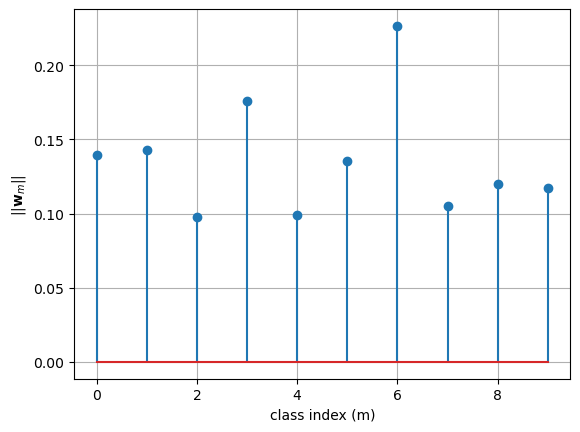

In [22]:
# w_norms = np.linalg.norm(W_hat, axis=0)
w_norms = np.linalg.norm(W_hat[1:], axis=0)

C = W_hat.shape[1]

plt.figure()
plt.stem(np.arange(C), w_norms)
plt.grid(':')
plt.xlabel('class index (m)')
plt.ylabel(r'$|| {\bf w}_m ||$')


## Evaluating and visualizing the MSE Classifier


Now that we have trained our multiclass linear regression system, we need to use it to make decisions.  I wrote a function that takese in the weight-vectors (as a 2D array) the augmented data matrix, and will evalute the MSE multiclass classifier.  It will also produce histograms of $g_m({\bf x})$ conditioned on the true class.  This allows us to see the misclassification rate when a given class is true.  It also shows us visually which classes are easily confused.  

I took some time to try to document this reasonably well because you can use this on your homework!

In [23]:

def plot_multiclass_histograms(X_aug, W, y, fname, norm_W=False, scale=1, class_names=None):
    """
    Keith Chugg, USC, 2023.

    X_aug: shape: (N, D + 1).  Augmented data matrix
    W: shape: (D + 1, C).  The matrix of augmented weight-vectors.  W.T[m] is the weight vector for class m
    y: length N array with int values with correct classes.  Classes are indexed from 0 up.
    fname: a pdf of the histgrams will be saved to filename fname
    norm_W: boolean.  If True, the w-vectors for each class are normalized.
    scale: use scale < 1 to make the figure smaller, >1 to make it bigger
    class_names: pass a list of text, descriptive names for the classes.  

    This function takes in the weight vectors for a linear classifier and applied the "maximum value methd" -- i.e., 
    it computes the argmax_m g_m(x), where g_m(x) = w_m^T x to find the decision. For each class, it plots the historgrams 
    of  g_m(x) when class c is true.  This gives insights into which classes are most easily confused -- i.e., similar to a 
    confusion matrix, but more information.  

    Returns: the overall misclassification error percentage
    """
    if norm_W:
       W = W / np.linalg.norm(W[1:], axis=0)
    y_soft = X_aug @ W
    N, C = y_soft.shape
    y_hard = np.argmax(y_soft, axis=1)
    error_percent = 100 * np.sum(y != y_hard) / len(y) 

    fig, ax = plt.subplots(C, sharex=True, figsize=(12 * scale, 4 * C * scale))
    y_soft_cs = []
    conditional_error_rate = np.zeros(C)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(C)]
    for c_true in range(C):
        y_soft_cs.append(X_aug[y == c_true] @ W)
        y_hard_c = np.argmax(y_soft_cs[c_true], axis=1)
        conditional_error_rate[c_true] = 100 * np.sum(y_hard_c != c_true) / len(y_hard_c)
    for c_true in range(C):
        peak = -100
        for c in range(C):
            hc = ax[c_true].hist(y_soft_cs[c_true].T[c], bins = 100, alpha=0.4, label=class_names[c])
            peak = np.maximum(np.max(hc[0]), peak)
            ax[c_true].legend()
            ax[c_true].grid(':')
        ax[c_true].text(0, 0.9 * peak, f'True: {class_names[c_true]}\nConditional Error Rate = {conditional_error_rate[c_true] : 0.2f}%')
    if norm_W:
        ax[C-1].set_xlabel(r'normalized discriminant function $g_m(x) / || {\bf w} ||$')
    else:
        ax[C-1].set_xlabel(r'discriminant function $g_m(x)$')
    plt.savefig(fname, bbox_inches='tight')
    return error_percent


Overall Misclassification Rate:  14.23%


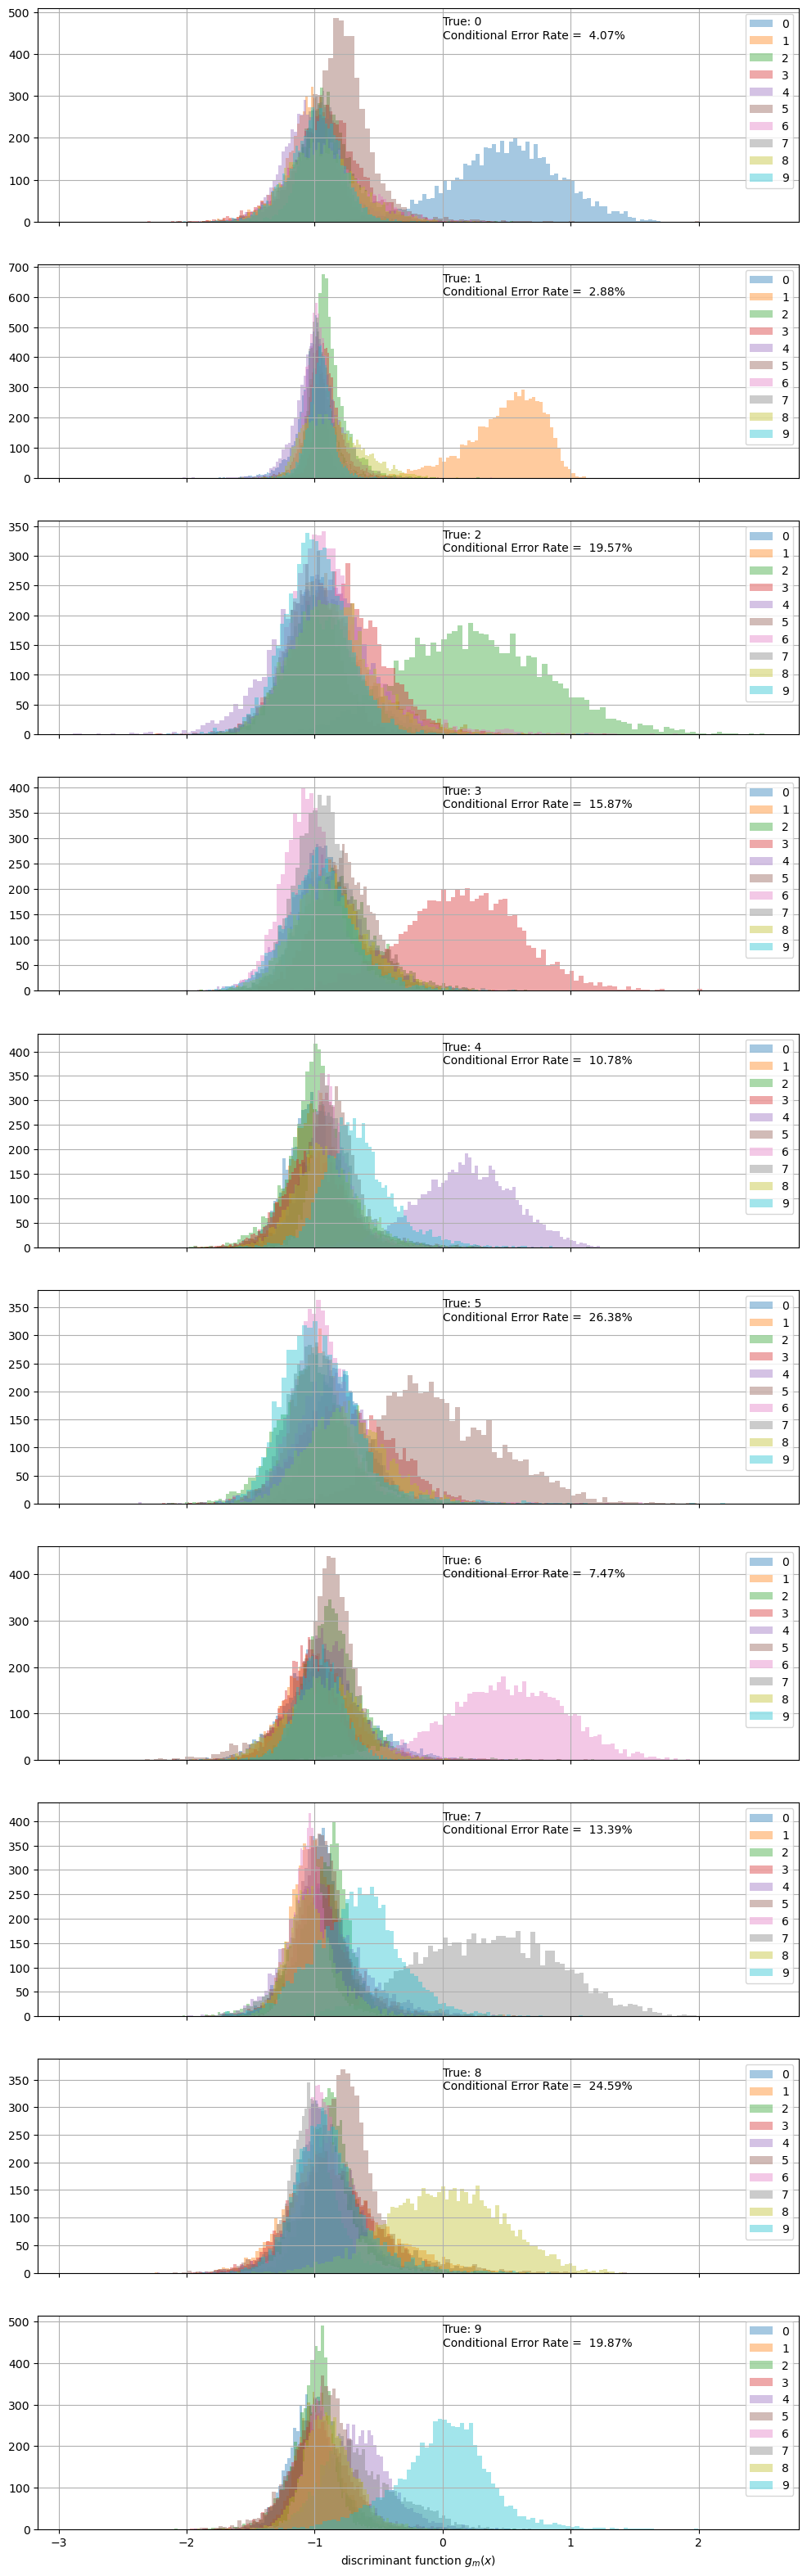

In [24]:
error_rate = plot_multiclass_histograms(x_train_aug, W_hat, y_train, f'img/hist_{tag_name}.pdf', scale=1, class_names=label_names)
print(f'\nOverall Misclassification Rate: {error_rate : 0.2f}%')

That is not too bad!  For FashionMNIST, we can see that when "shirt" is true, it is easily confused for many other classes!

Also, if you look above, it is class 5 which has the w-vector with smallest norm (FashionMNIST).  Would it make more sense to maximize ${\bf w}_m{\bf x}/ \| {\bf w}_m\|$?  Note that this is the distance to the decision boundary for the impicit one-vs-rest test.  

Let's try that out, it's buit into `plot_multiclass_histograms()` function with the `norm_W` optional argument.


Overall Misclassification Rate:  15.16%


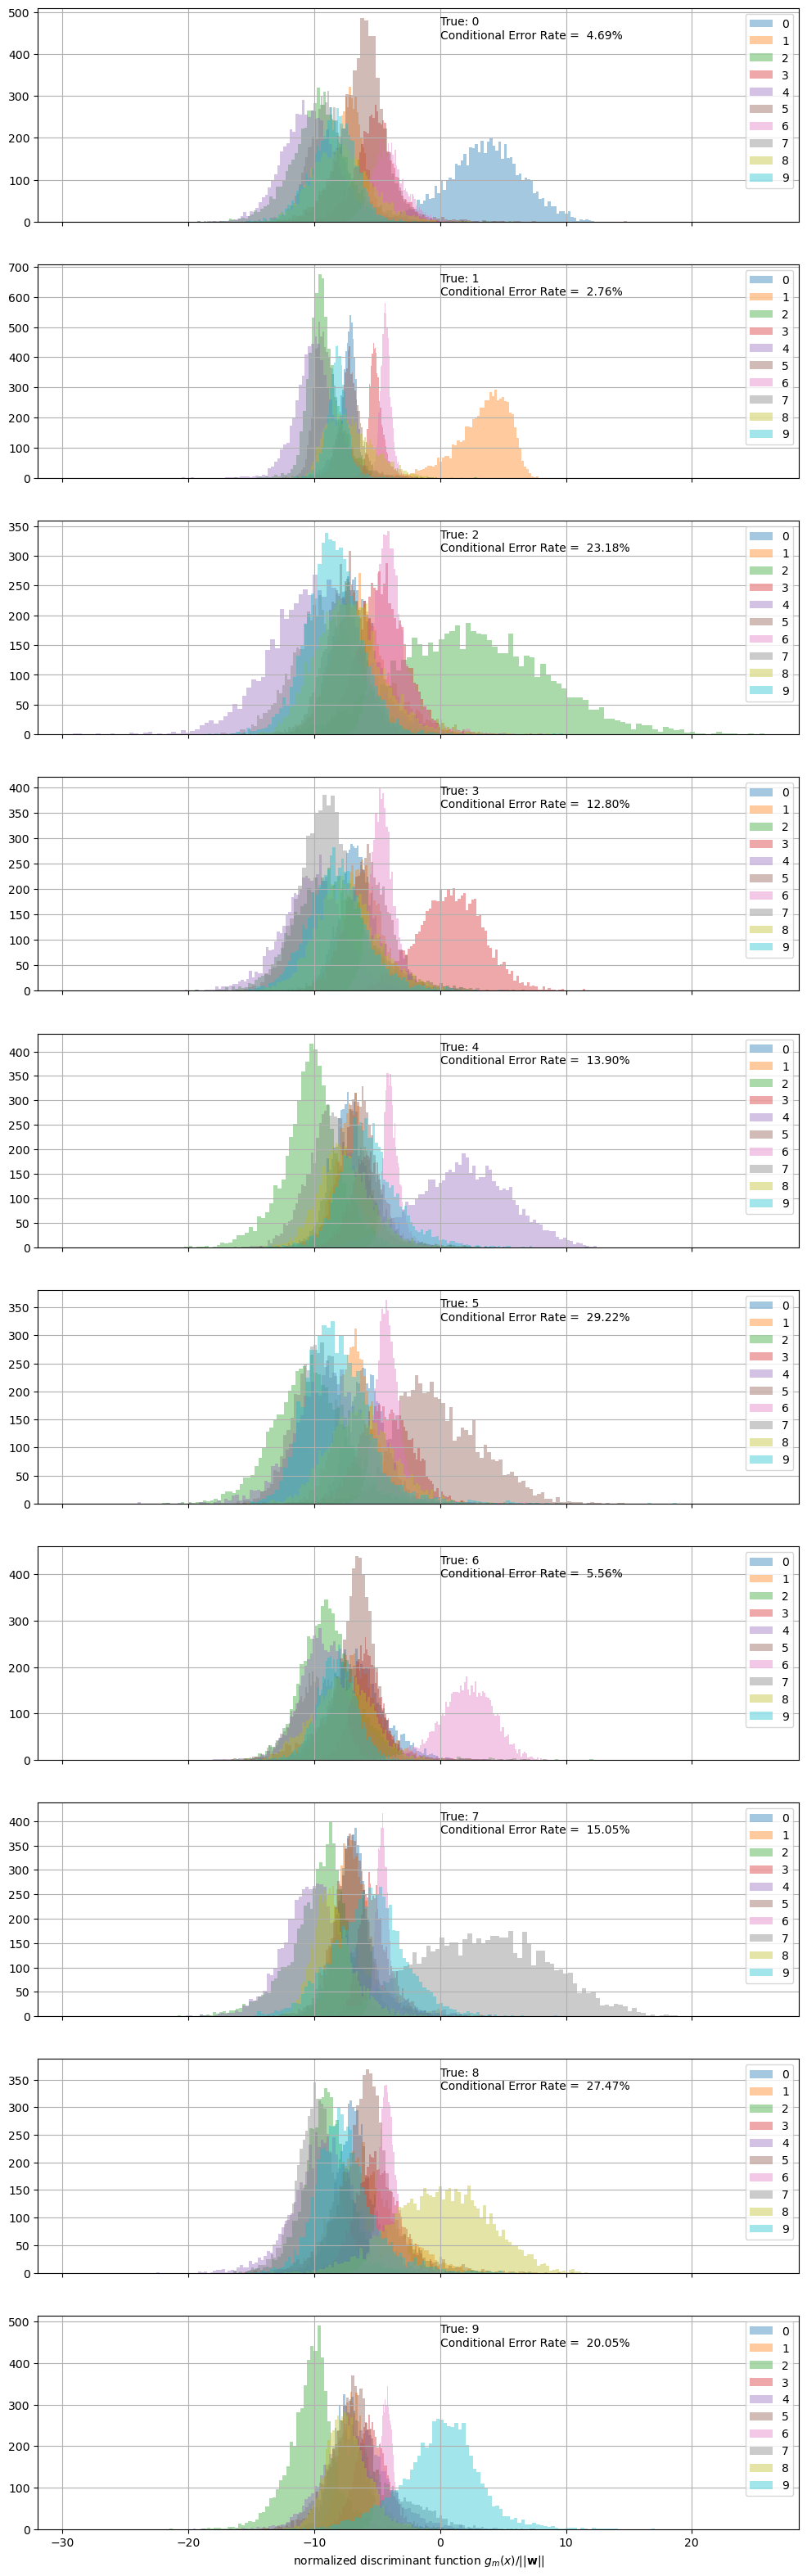

In [25]:
error_rate = plot_multiclass_histograms(x_train_aug, W_hat, y_train, f'img/hist_{tag_name}.pdf', norm_W=True, scale=1, class_names=label_names)
print(f'\nOverall Misclassification Rate: {error_rate : 0.2f}%')

Note that using `norm_W` as `True` or `False` provides two different decision (or fusion) rules for combining the OvR classifiers.  Which do you think performs better?

We can also argue that there is a real issue with an MSE classifier.

For example, given that the target of the true class is $+1$, when the true class is $k$, if discriminant function is $g({\bf x}) \gg +1$ it should be a high confidence decision that class $k$ is true.  However, the squared error loss actually penalizes for this -- e.g., $g({\bf x}) = +10$ incurs a huge penalty while $g({\bf x})=+1$ incurs no penalty.  

This can be addressed with multiclass logistic regression where the max operation over all $g_m({\bf x})$ is replaced by a multiclass softmax function.  This is multiclass logistic regression.  This doesn't have a closed form solution and requires gradient descent to solve. 